In [6]:
import h5py
folder = "/home/eric/tiny-differentiable-simulator/data/mit-push/abs_rect1/"
file = folder + "motion_surface=abs_shape=rect1_a=0_v=20_i=0.000_s=0.700_t=0.000_rep=0004.h5"

with h5py.File(file, "r") as f:
    print("Keys: %s" % f.keys())

    # Get the data
    object_poses = list(f["object_pose"])
    tip_poses = list(f["tip_pose"])

Keys: <KeysViewHDF5 ['ft_wrench', 'object_pose', 'tip_pose']>


(0.28975707945169926,
 0.3642556063056882,
 0.0018272558000162848,
 0.05053657980769665)

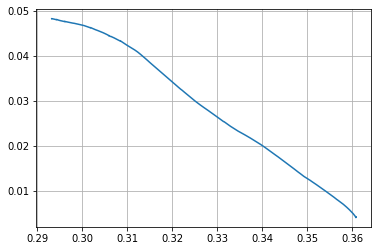

In [23]:
import matplotlib.pyplot as plt
import numpy as np

obj_poses_2d = np.array(object_poses)[:,1:3]
plt.plot(obj_poses_2d[:,0], obj_poses_2d[:,1])
plt.grid()
plt.axis('equal')

In [24]:
def visualize(filename):
    with h5py.File(filename, "r") as f:
        # Get the data
        object_poses = list(f["object_pose"])
        tip_poses = list(f["tip_pose"])
        obj_poses_2d = np.array(object_poses)[:,1:3]
        plt.plot(obj_poses_2d[:,0], obj_poses_2d[:,1])

(0.25856311199488596,
 0.5045409311447795,
 -0.12892365643878154,
 0.12031552872145565)

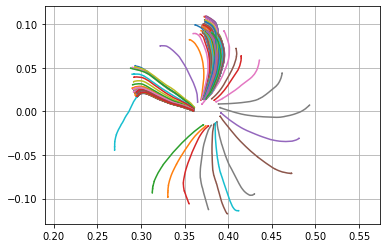

In [27]:
import glob
for file in glob.glob(folder + "*.h5"):
    visualize(file)
plt.grid()
plt.axis('equal')

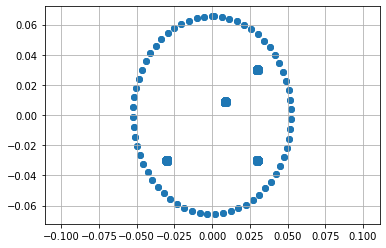

In [51]:
vertices = load_vertices(folder + "../obj/ellip2.obj")
plt.scatter(vertices[:,0], vertices[:,2])
plt.axis("equal")
plt.grid()

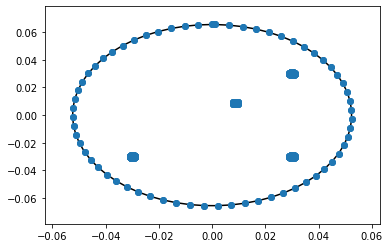

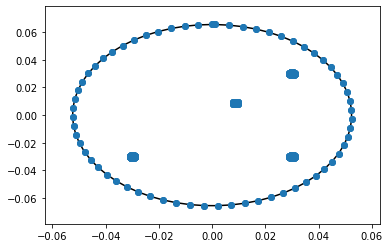

In [59]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(vertices[:, [0,2]])
hull.close()
convex_hull_plot_2d(hull)

In [66]:
"Smallest y coordinate:", np.min(vertices[:, 1])

('Smallest y coordinate:', -0.00635)

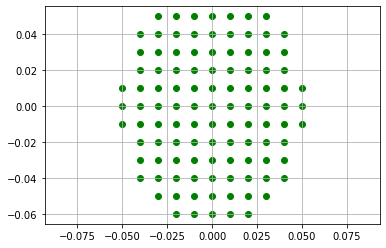

In [67]:
from scipy.spatial import Delaunay
step = 0.01

min_y = np.min(vertices[:, 1])
max_y = np.max(vertices[:, 1])
center_y = 0.5 * (min_y + max_y)
diameter_y = max_y - min_y

collision_points = []

delaunay = Delaunay(vertices[:, [0,2]])
for x in np.arange(start=-0.06, stop=0.06, step=step):
    for y in np.arange(start=-0.06, stop=0.06, step=step):
        p = np.array([x, y])
        if delaunay.find_simplex(p)>=0:
            plt.scatter([x], [y], c="g")
            collision_points.append(np.array([x, center_y, y]))
plt.axis("equal")
plt.grid()

In [68]:
collision_urdf = ""
for cp in collision_points:
    collision_urdf += """
    <collision>
      <origin rpy="0 0 0" xyz="%.4f %.4f %.4f"/>
      <geometry>
        <sphere radius="%.4f"/>
      </geometry>
    </collision>
    """ % (cp[0], cp[1], cp[2], diameter_y * 0.51)

urdf = """<?xml version="1.0" ?>
<robot name="urdf_robot">
  <link name="baseLink">
    <contact>
      <rolling_friction value="0.03"/>
      <spinning_friction value="0.03"/>
    </contact>

    <inertial>
      <origin rpy="0 0 0" xyz="0 0 0"/>
       <mass value="10.0"/>
       <inertia ixx="1" ixy="0" ixz="0" iyy="1" iyz="0" izz="1"/>
    </inertial>
    <visual>
      <origin rpy="0 0 0" xyz="0 0 0"/>
      <geometry>
        <mesh filename="ellip1.obj" scale="1.0 1.0 1.0"/>      
      </geometry>
      <material name="gray">
        <color rgba="0.5 0.5 0.5 1"/>
        <specular rgb="1 1 1"/>
      </material>
    </visual>
    %s
  </link>
</robot>
""" % collision_urdf

with open("ellip2.urdf", "w") as file:
    file.write(urdf)
